In [1]:
from LABNET import Neuron, Net

In [2]:
dl_big = [
    ['i']
    ,['i']
    ,['i']
    ,['i']
    ,['i']
    ,['i']
    ,['i']
    ,['i'] #0-7 for inputs
    
    ,['fc',[0,1,2]]
    ,['fc',[-2,3,-4]]
    ,['fc',[3,4,5]]
    ,['fc',[3,5,7]]
    ,['fc',[0,7]] #8 - 12 for this layer
    
    ,['fc',[8,10]]
    ,['fc',[9,-11]]
    ,['fc',[12]]
    ,['fc',[-8,-9]] #13 - 16
    
    
    
    ,['o',[-13,14]]
    ,['o',[-14,15,-16]]
    ,['o',[-15,-16]]
    ,['o',[-13,16]]
    
]

In [3]:
nn_big = Net(dl_big)
nn_big.generate_inputs()
nn_big.generate_outputs()
nn_big.tensorize()

self.inputs and self.outputs are now tensors of shape torch.Size([256, 8]) and torch.Size([256, 4]) respectively!


In [4]:
nn_big.outputs

tensor([[False,  True, False, False],
        [False, False,  True, False],
        [False,  True, False, False],
        ...,
        [False, False, False,  True],
        [False, False, False,  True],
        [False, False, False,  True]])

In [5]:
nn_big.percent_true()

[tensor(0.0938), tensor(0.0781), tensor(0.1562), tensor(0.7500)]

In [6]:
nn_big.input_size

8

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

In [8]:
# Define the model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden_1 = nn.Linear(nn_big.input_size, 5) ##make these all variables duh
        self.hidden_2 = nn.Linear(5,4)
        self.output = nn.Linear(4, nn_big.output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden_1(x))
        x = self.relu(self.hidden_2(x))
        x = self.output(x)
        return x

In [9]:
model = MyModel()

In [10]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [11]:
input_data = nn_big.inputs.float()
output_data = nn_big.outputs.float()

In [12]:
input_data.dtype

torch.float32

In [41]:
# Training loop
num_epochs = 5
hidden_layer_weights = torch.zeros(num_epochs, 5, 8) #this should be num epochs by hidden size.  
for epoch in range(num_epochs):
    # Forward pass
    output = model(input_data)
    ###this needs to be stochastic
    # Compute the loss
    loss = criterion(output, output_data)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss.item()

    print(model.hidden_1.weight.shape) ##i also have biases here.  are those interesting??
    hidden_layer_weights[epoch] = model.hidden_1.weight
    print(model.hidden_2.weight)
    print(model.output.weight)

# After training, you can use the model to make predictions
test_input = torch.randn(1, 8)  # Single test input with 8 values
predicted_output = model(test_input)
print("Predicted output:", predicted_output)

torch.Size([5, 8])
Parameter containing:
tensor([[ 0.3946, -0.1893,  0.0206,  0.1015, -0.3951],
        [-0.3002, -0.1381,  0.0515,  0.0702, -0.0453],
        [ 0.4303,  0.4424, -0.1680, -0.2123,  0.0857],
        [-0.2787, -0.2555,  0.3016,  0.3647, -0.2665]], requires_grad=True)
Parameter containing:
tensor([[-0.3817,  0.0837, -0.3262,  0.4773],
        [-0.1825, -0.1167, -0.3814, -0.0823],
        [-0.3754,  0.1148, -0.3220,  0.1330],
        [-0.4102, -0.1181,  0.1509,  0.2353]], requires_grad=True)
torch.Size([5, 8])
Parameter containing:
tensor([[ 0.3946, -0.1894,  0.0206,  0.1015, -0.3951],
        [-0.3002, -0.1381,  0.0515,  0.0702, -0.0453],
        [ 0.4303,  0.4423, -0.1680, -0.2122,  0.0857],
        [-0.2787, -0.2555,  0.3016,  0.3647, -0.2665]], requires_grad=True)
Parameter containing:
tensor([[-0.3818,  0.0837, -0.3263,  0.4773],
        [-0.1825, -0.1167, -0.3814, -0.0823],
        [-0.3755,  0.1148, -0.3220,  0.1330],
        [-0.4099, -0.1181,  0.1511,  0.2353]], re

In [43]:
hidden_layer_weights.shape

torch.Size([5, 5, 8])

[[-0.3469815  -0.07292336 -0.02228806  0.191466   -0.32438868  0.20894802
   0.13477889  0.04567388  0.15456189  0.3543305  -0.32375628  0.2706515
  -0.14525518 -0.2929066  -0.30148655 -0.31950286  0.1159891  -0.30396482
  -0.01757064 -0.1349488  -0.18273373 -0.05090491 -0.12745696  0.05740287
   0.25836584 -0.11272006 -0.17629027 -0.34156716  0.16930735  0.18105668
  -0.19269498 -0.27565905 -0.2860846   0.22715165  0.12871066 -0.10191232
  -0.26817885  0.26160175  0.15045121 -0.25639096]
 [-0.34700385 -0.07295312 -0.02223665  0.19136718 -0.32436424  0.20893222
   0.13475043  0.04566606  0.15455231  0.35433528 -0.32376403  0.27060962
  -0.14519884 -0.29291072 -0.30149418 -0.31950903  0.1159822  -0.30396482
  -0.01757347 -0.1349488  -0.18273373 -0.0509081  -0.12745696  0.05739906
   0.25832123 -0.11274029 -0.17630894 -0.34157637  0.1692496   0.18100667
  -0.19272643 -0.27568305 -0.28608537  0.22716624  0.1287199  -0.10190281
  -0.26817703  0.26161805  0.15046334 -0.25638735]
 [-0.347026

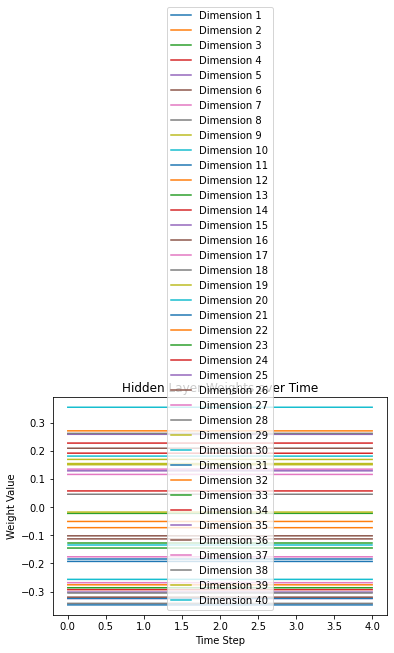

In [61]:
import matplotlib.pyplot as plt
import numpy as np
weights = hidden_layer_weights.detach().numpy()

shapes = weights.shape
weights = np.reshape(weights,(shapes[0],shapes[1]*shapes[2]))
print(weights)
# Get the number of time steps and dimensions
num_time_steps, num_dimensions = weights.shape
print(num_time_steps,num_dimensions)
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the lines for each dimension
for i in range(num_dimensions):
    ax.plot(range(num_time_steps), weights[:, i], label=f"Dimension {i+1}")

# Set the labels and title
ax.set_xlabel('Time Step')
ax.set_ylabel('Weight Value')
ax.set_title('Hidden Layer Weights over Time')

# Add a legend
ax.legend()

# Show the plot
plt.show()